# Exploración de Modelos, Validación y Interpretabilidad



### Objetivos:

1. Entrenar múltiples modelos (RandomForest, GradientBoosting) con validación cruzada
   y ajuste de hiperparámetros (GridSearchCV).
2. Seleccionar el mejor modelo basado en su desempeño.
3. Evaluar el modelo seleccionado en un conjunto de prueba.
4. Interpretar el modelo final usando la librería SHAP.

### Requisitos:


#### Autor: Gabriela Durán Meza

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

from nltk.corpus import stopwords
import nltk

import warnings
warnings.filterwarnings("ignore")

### 1. Carga de datos 

In [14]:
df = pd.read_csv(r"C:\Users\igaby\OneDrive\Documents\MEGA\ds_projects\traxion\silver\driver_data_with_messages_fe.csv")
print(df.columns)

Index(['driver_id', 'tag', 'age', 'salary', 'education', 'marital_status',
       'years_experience', 'num_prev_employers', 'trip_duration',
       'distance_traveled', 'risk_zone', 'high_prob_leave', 'message',
       'salario_por_km', 'experiencia_normalizada', 'salario_por_duracion',
       'is_solo_provider', 'zona_alta_y_sueldo_bajo'],
      dtype='object')



### 2. Definición de variables predictoras (X) y variable objetivo (y)

In [15]:
# Variables por tipo
numeric_cols = [
    'age', 'salary', 'years_experience', 'num_prev_employers',
    'trip_duration', 'distance_traveled', 'salario_por_km',
    'experiencia_normalizada', 'salario_por_duracion'
]

categorical_cols = ['education', 'marital_status', 'risk_zone', 'zona_alta_y_sueldo_bajo']
text_col = 'message'

features = numeric_cols + categorical_cols + [text_col]
target = 'high_prob_leave'

# Separación de datos
X = df[features]
y = df[target]


### 3. Preprocesamiento de datos
   - Escalado de variables numéricas
   - Codificación One-Hot de variables categóricas


In [16]:
# Descargar stopwords de NLTK si es la primera vez
#nltk.download('stopwords')

# 🧹 Lista de palabras comunes en español
spanish_stopwords = stopwords.words('spanish')

# 🔢 Transformador para columnas numéricas
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 🔠 Transformador para columnas categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Transformador de texto con TF-IDF y stopwords en español
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        max_features=300,
        stop_words=spanish_stopwords,  # stopwords en español
        ngram_range=(1, 1)
    ))
])

# Ensamble de transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('txt', text_transformer, text_col)
    ]
)



### 4. Definición de modelos y búsqueda de hiperparámetros con validación cruzada



In [17]:
# Modelos y sus parámetros
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

params = {
    'RandomForest': {
        'clf__n_estimators': [50],
        'clf__max_depth': [5]
    },
    'GradientBoosting': {
        'clf__n_estimators': [50],
        'clf__learning_rate': [0.1]
    }
}

# Entrenar y validar cada modelo
best_models = {}
for model_name, model_obj in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('clf', model_obj)
    ])
    
    grid = GridSearchCV(pipe, param_grid=params[model_name], cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X, y)
    
    best_models[model_name] = grid.best_estimator_
    
    print(f"Modelo: {model_name}")
    print(f"Mejores parámetros: {grid.best_params_}")
    print(f"Mejor accuracy (validación): {grid.best_score_:.4f}\n")

Modelo: RandomForest
Mejores parámetros: {'clf__max_depth': 5, 'clf__n_estimators': 50}
Mejor accuracy (validación): 0.8830

Modelo: GradientBoosting
Mejores parámetros: {'clf__learning_rate': 0.1, 'clf__n_estimators': 50}
Mejor accuracy (validación): 0.9620





### 5. Seleccionar el mejor modelo en función de su desempeño global



In [18]:
# Seleccionar el mejor modelo
best_model_name = max(best_models, key=lambda name: best_models[name].score(X, y))
best_model = best_models[best_model_name]

# Evaluar en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f"\nMejor modelo seleccionado: {best_model_name}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))



Mejor modelo seleccionado: GradientBoosting

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       492
           1       0.98      0.83      0.90       108

    accuracy                           0.97       600
   macro avg       0.97      0.91      0.94       600
weighted avg       0.97      0.97      0.97       600

Matriz de Confusión:
[[490   2]
 [ 18  90]]


In [20]:
# 1. Generar el reporte de clasificación como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# 2. Convertir el diccionario en un DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 3. Exportar el DataFrame a un archivo Excel
#report_df.to_excel(r"C:\Users\igaby\OneDrive\Documents\MEGA\ds_projects\traxion\gold\classification_report.xlsx", index=True)

#print("El archivo classification_report.xlsx se ha creado con éxito.")

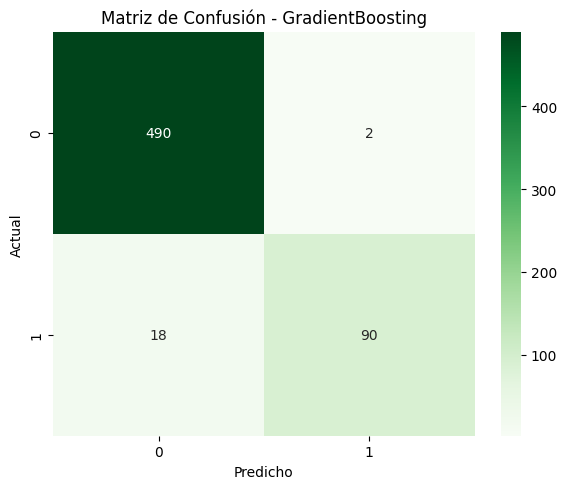

In [21]:
# Graficar matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(
    pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicho"]),
    annot=True,
    fmt="d",
    cmap="Greens"
)
plt.title("Matriz de Confusión - GradientBoosting")
plt.tight_layout()
plt.show()

### 6. Importancia de variables.

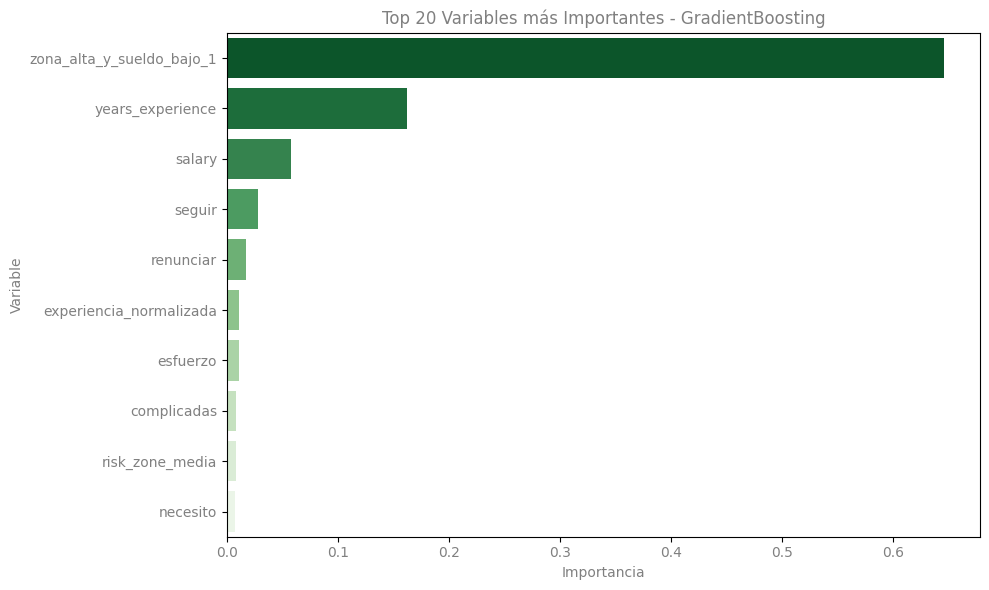

In [26]:
# Obtener importancia de variables del modelo final
final_clf = best_model.named_steps['clf']
transformer = best_model.named_steps['preprocessor']

# Obtener nombres de features transformados
ohe_feature_names = transformer.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)
text_features = transformer.named_transformers_['txt']['tfidf'].get_feature_names_out()
feature_names = numeric_cols + list(ohe_feature_names) + list(text_features)

# Obtener importancias y ordenarlas
importances = final_clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Crear paleta verde
green_palette = sns.color_palette("Greens_r", n_colors=10)  # _r para invertir (más intensos arriba)

# Gráfico de las 20 variables más importantes
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(10),
    x='importance',
    y='feature',
    palette=green_palette
)

# Cambiar el color de los textos a gris
plt.title(f"Top 20 Variables más Importantes - {best_model_name}", color='gray')
plt.xlabel("Importancia", color='gray')
plt.ylabel("Variable", color='gray')
plt.xticks(color='gray')
plt.yticks(color='gray')
plt.tight_layout()
plt.show()